# This notebook demonstrates a practical application of convolutional filtering.  

The filter is applied to data downloaded from the SeiscomP3 data repository using the python ObsPy package., https://docs.obspy.org/packages/index.html.  To download the data I modified the 07_Find_and_analyse_seismograph_data.ipynb notebook from https://github.com/agile-geoscience/xlines.   A landslide in Greenland described in the original notebook is downloaded, but it should be possible to download other data, including data in the IRIS data repository.

Removing noise is a common step in data analysis.  Convolutional filters are often used.  If the noise is higher frequency than the signal you can use a high cut filter.  A high cut filter removes high frequencies and “passes” low frequencies.  A high cut filter is also called a low pass filter.  You can read more at: https://en.wikipedia.org/wiki/Low-pass_filter

Filters have many uses and filter design is an advanced topic.  In this notebook the filter design is in the function “design_highcutfilter”.  There are four parameters:
  •	sample_rate in hz of the data.  250hz is a sample period of .004 seconds
  •	width=10 width of the transition 
  •	ripple=60 error in db in the pass and stop band.  Larger value is more accurate.
  •	cutoff_hz=10 cut off frequency

The frequency response of the filter is approximately 1 in the pass band,  below cutoff_hz-width/2, and approximately 0 in the stop band, above cutoff_hz+width/2.  There is a transition between cutoff_hz-width/2 and cutoff_hz+width/2.  Filter accuracy is controlled by ripple. 

The algorithm for convolution is:
1.	flip the filter
2.	line the filter up with the input signal
3.	multiply the lined up filter and signal amplitudes
4.	sum the products
5.	send the sum to the output array
6.	while there is more output to compute, shift the filter “one to the right” and return to 3.

A detail in the step 2 is time 0 in the output signal is computed by lining up time 0 on the input signal and time 0 of the flipped filter.  Numpy.convolve and sp.signal.lfilter define the first sample of the filter to be time zero.  This is not always what we want to do.  The function “design_highcutfilter” returns a symmetric or “zero phase filter”.  Time 0 of the filter at the center.   The function “apply_0ph_filt” removes the delay.

The function “design_highcutfilter” was derived from: 
http://scipy-cookbook.readthedocs.io/items/FIRFilter.html



# The filter exercise
To run you must have:<br>
python 3<br>
conda install basemap cartopy<br>

Most of this notebook is included for future reference.  The exercise starts with the section:

### Design a filter and apply it to the network="DK", station="NUUG"

Skip down to that section and follow the intructions to experiment with the applying high cut filters to the landslide data.


In [1]:
# just a little spacer comment

# Find and analyse global seismic data

From x lines of Python

This notebook goes with [the blog post](https://agilescientific.com/blog/2017/9/8/x-lines-of-python-global-seismic-data) of 8 September 2017. We'll look at 3 non-earthquakes:

1. A landslide and tsunami in Greenland, June 2017.
1. A nuclear weapon test in North Korea, September 2017.
1. A hurricane in the west Atlantic, September 2017.

Plus one earthquake — the estimated M8.2 off Mexico this morning, 8 September 2017.


## Landslide in Greenland

There was [a landslide in Greenland](http://temblor.net/earthquake-insights/greenland-earthquake-was-a-phantom-the-landslide-and-tsunami-were-real-4468/) in June. It triggered a fatal tsunami ([video](https://www.youtube.com/watch?v=LzSUDBbSsPI)). When I saw [Jascha Polet's tweet](https://twitter.com/CPPGeophysics/status/876502352710086656) about it, I was curious. [Ari Hartikainen's later tweet](https://twitter.com/a_hartikainen/status/878006334809034752) really made me want to look at the data.

Now let's get started!

First some preliminaries to make sure we get inline plots, and to turn off some matplotlib 2.0 warnings about a call ObsPy is making in its plotting functions somewhere.

In [2]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

print ("sys.version=",sys.version)

sys.version= 3.5.4 | packaged by conda-forge | (default, Dec 18 2017, 06:40:48) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


In [1]:
from obspy.clients.fdsn import Client
client = Client("GFZ")

FDSNException: No FDSN services could be discovered at 'http://geofon.gfz-potsdam.de'. This could be due to a temporary service outage or an invalid FDSN service address.

I'm just following the [instructions in the ObsPy documentation](https://docs.obspy.org/packages/obspy.clients.fdsn.html).

The event was at about 2340 UTC, but I'm going to grab a 2 hours' worth of data, starting well before the landslide event. You'll see why in a minute.

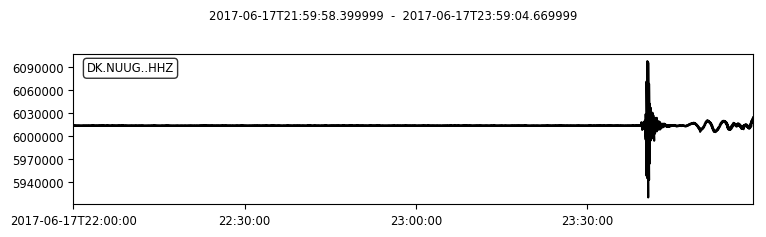

In [5]:
from obspy import UTCDateTime
t = UTCDateTime("2017-06-17_22:00:00")
st = client.get_waveforms("DK", "NUUG", "*", "HHZ", t, t + 2*60*60)
st.plot()  

dknuug0.size= 714628


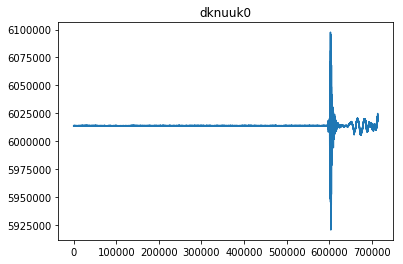

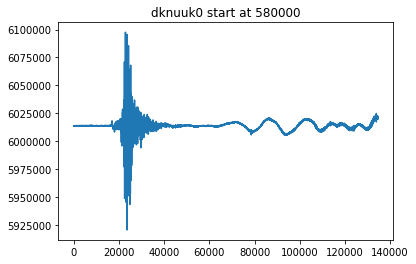

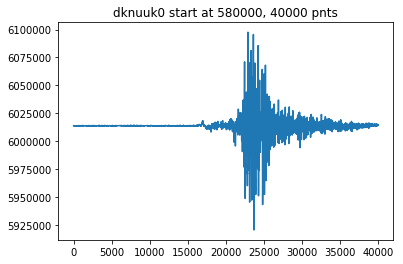

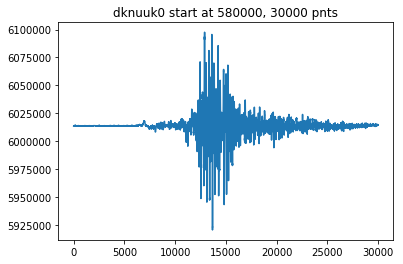

In [6]:
dknuug0 = st.traces[0].data
print('dknuug0.size=',dknuug0.size)

plt.title('dknuuk0')
plt.plot(dknuug0)
plt.show()

plt.title('dknuuk0 start at 580000')
plt.plot(dknuug0[580000:])
plt.show()

plt.title('dknuuk0 start at 580000, 40000 pnts')
plt.plot(dknuug0[580000:580000+40000])
plt.show()
plt.title('dknuuk0 start at 580000, 30000 pnts')
plt.plot(dknuug0[590000:580000+40000])
plt.show()

Notice the landslide event, followed by the periodic signal of the tsunami.

What's **HHZ**? Seismic stations have lots of instruments and make their waveforms availables as various different channels, depending on the station. For example:
    
- `LHZ`: long period ~1 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- `BHZ`: broadband 10–80 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- `HHZ`: broadband 80–250 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- Some stations have loads of others, see Appendix A in [the SEED Manual](http://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf).

## Where is the station?

ObsPY is pretty cool. It can draw a map showing us where stations and events are.

Note that to do this you need `basemap` and `cartopy`:

    conda install basemap
    conda install cartopy

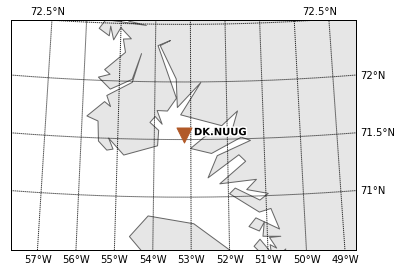

In [7]:
inventory = client.get_stations(network="DK", station="NUUG")
inventory.plot(projection='local')  # Can be global or ortho or local (at low res by default)
plt.show()

In [8]:
inventory

Inventory created at 2018-02-21T21:33:16.105634Z
	Sending institution: SeisComP3 (GFZ)
	Contains:
		Networks (1):
			DK
		Stations (1):
			DK.NUUG (Nuugaatsiq, Greenland)
		Channels (0):


## Get the data from the stream

The ObsPy stream object contains all our data:

In [9]:
st

1 Trace(s) in Stream:
DK.NUUG..HHZ | 2017-06-17T21:59:58.399999Z - 2017-06-17T23:59:04.669999Z | 100.0 Hz, 714628 samples

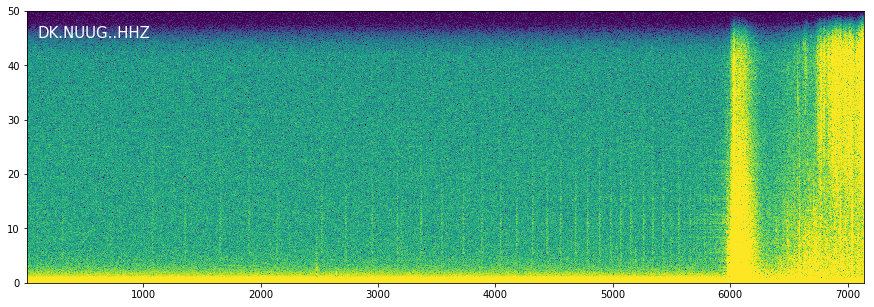

In [10]:
z = st.traces[0].data
NFFT = 2048
Fs = st.traces[0].meta.sampling_rate  # Sample rate in Hz
label = "{network}.{station}.{location}.{channel}".format(**st.traces[0].meta)

plt.figure(figsize=(15, 5))
Pxx, freqs, bins, im = plt.specgram(z, NFFT=NFFT, Fs=Fs, noverlap=int(0.9*NFFT), cmap='viridis', vmin=-30, vmax=30)
plt.text(100, 45, label, size=15, color='white')
plt.show()

Notice the increasingly frequent signals preceeding the landslide event. You can hear them in [the sonification of this event](http://ds.iris.edu/files/products/seissound/data/Movie/10228170_DK_NUUG_HHZ_2017_06_17_233912_vco_720.mp4) — and listen for the tsunami after the crash. 


<hr>

**&copy; 2017 [agilescientific.com](https://www.agilescientific.com/) and licensed [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)**

In [11]:
def design_highcutfilter(sample_rate,width=10,ripple=60,cutoff_hz = 10.0):
    '''
    create a zero phase highcut filter ising kaiser window function.
    sample_rate in hz of the data.  250hz is a sample period of .004 seconds
    width=10 width of the transition 
    ripple=60 error in db in the pass and stop band
    cutoff_hz=10 cut off frequency
    
    The frequency response of the filter is approximately 1 in the pass band, 
    below cutoff_hz-width/2, and approximately 0 in the stop band, above cutoff_hz+width/2.
    There is a transition between cutoff_hz-width/2 and cutoff_hz+width/2.
    '''
    #------------------------------------------------
    # Create a FIR filter and apply it to x.
    #------------------------------------------------

    # The Nyquist rate of the signal.
    nyq_rate = sample_rate / 2.0

    # width is the desired width of the transition from pass to stop,
    # relative to the Nyquist rate.  default is design the filter
    # with a 5 Hz transition width.

    # The desired attenuation in the stop band, in dB. Default is 60

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = sp.signal.kaiserord(ripple, width/nyq_rate)
    # I want an odd filter length.  If N, the filter length, is even increase by 1.
    if N%2 == 0:
        N=N+1

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = sp.signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

    #------------------------------------------------
    # Plot the FIR filter coefficients.
    #------------------------------------------------

    plt.figure(1)
    plt.plot(taps, 'bo-', linewidth=2)
    plt.title('Filter Coefficients (%d taps)' % N)
    plt.grid(True)

    #------------------------------------------------
    # Plot the magnitude response of the filter.
    #------------------------------------------------

    plt.figure(2)
    plt.clf()
    w, h = sp.signal.freqz(taps, worN=8000)
    plt.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title('Frequency Response')
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    # Upper inset plot.
    plt.ax1 = plt.axes([0.42, 0.6, .45, .25])
    plt.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
    plt.xlim(0,8.0)
    plt.ylim(0.9985, 1.001)
    plt.grid(True)

    # Lower inset plot
    plt.ax2 = plt.axes([0.42, 0.25, .45, .25])
    plt.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
    plt.xlim(12.0, 20.0)
    plt.ylim(0.0, 0.0025)
    plt.grid(True)
    plt.show()

    return taps

def apply_0ph_filt(filter,x):
    filtered_x = sp.signal.lfilter(filter, 1.0, x)
    return filtered_x[(filter.size-1)//2:]


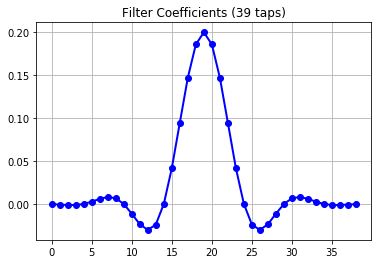

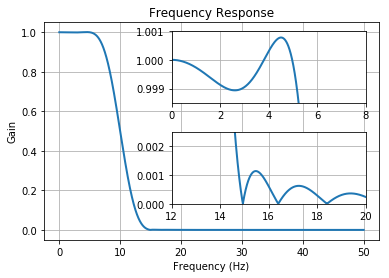

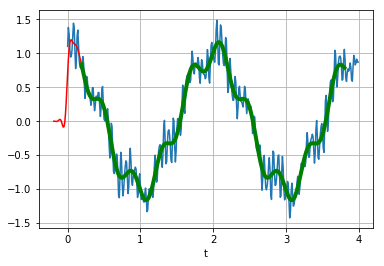

In [12]:
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = np.arange(nsamples) / sample_rate
x = np.cos(2*np.pi*0.5*t) + 0.2*np.sin(2*np.pi*2.5*t+0.1) + \
        0.2*np.sin(2*np.pi*15.3*t) + 0.1*np.sin(2*np.pi*16.7*t + 0.1) + \
            0.1*np.sin(2*np.pi*23.45*t+.8)


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------
taps=design_highcutfilter(sample_rate,width=10,cutoff_hz = 10.0)

# Use lfilter to filter x with the FIR filter.
filtered_x = sp.signal.lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (taps.size-1) / sample_rate

plt.figure(3)
# Plot the original signal.
plt.plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plt.plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plt.plot(t[taps.size-1:]-delay, filtered_x[taps.size-1:], 'g', linewidth=4)

plt.xlabel('t')
plt.grid(True)

plt.show()



# Design and apply a filter to network "DK", station "NUUG"
These eamples use python array slicing.  You can select a subset of an array.  For example this code snippet:
'''
x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
xsubset=x[1:7:2]
xsubset
'''
will print:
array([1, 3, 5])

The basic syntax is x[i:j:k].  i is the starting index, j the stopping index, and k is the increment.  Notice the stopping index is just past the last value to be output in the slice.

You donot need to use all of i,j,k.  For example:
x[8:] will output array([8, 9])
x[:3] will output array([0,1,2])
x[::2] will output array([0,2,4,6,8])

There is more information at:
https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html


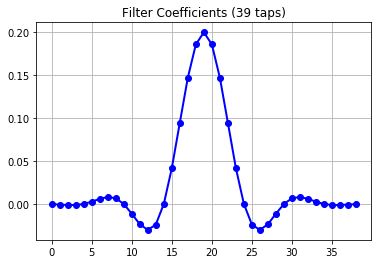

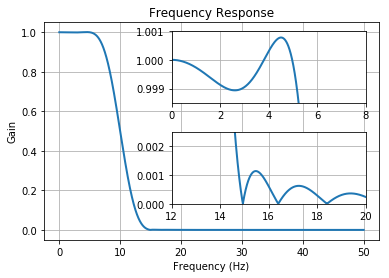

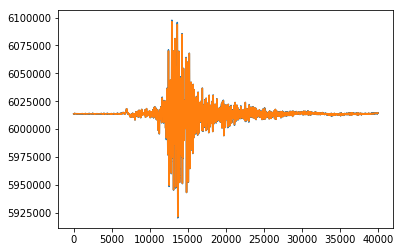

In [13]:
#---------------------------------------------------------
# Create a filter and apply it to the sesismogram dknuug0.
#---------------------------------------------------------
filter10=design_highcutfilter(sample_rate,width=10,cutoff_hz = 10.0)

# Use apply_0ph_filt to filter x with the FIR filter.
dknuug0_filtered10 = apply_0ph_filt(filter10, dknuug0)

plt.plot(dknuug0[590000:590000+40000])

plt.plot(dknuug0_filtered10[590000:590000+40000])
plt.show()




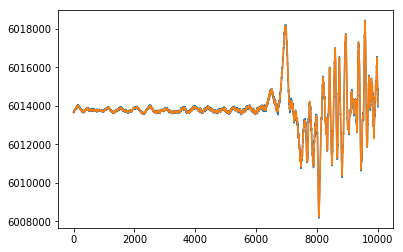

In [14]:
# zoom on small onset near sample 6000 above
plt.plot(dknuug0[590000:590000+10000])

plt.plot(dknuug0_filtered10[590000:590000+10000])
plt.show()



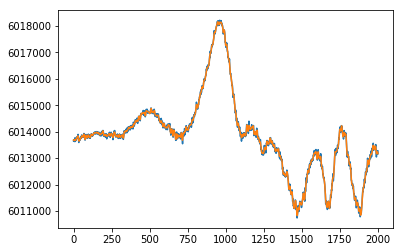

In [15]:
# zoom on even smaller onset near sample 6000 above.   Only 2000 points

plt.plot(dknuug0[596000:596000+2000])

plt.plot(dknuug0_filtered10[596000:596000+2000])
plt.show()



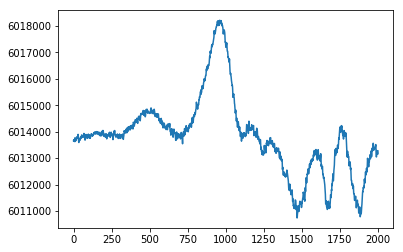

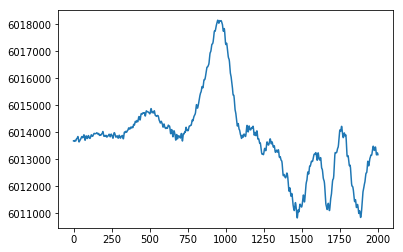

In [16]:
# plot input and output separately to observe if 
# filterred signal is smoother.

plt.plot(dknuug0[596000:596000+2000])
plt.show()
plt.plot(dknuug0_filtered10[596000:596000+2000])
plt.show()



## Now it is your turn.  
Change the ? in the following code and run these test to see 
the effect of changing the cutoff_hz.  Compare an 8 and 4 hz highcut to the 10 hz highcut.

To run a 4 hz highcut you need to change the width.  The transition zone is [cutoff_hz-width/2,cutoff_hz+width/2].  Width should be small enough so that cutoff_hz-width/2 is non-negative.


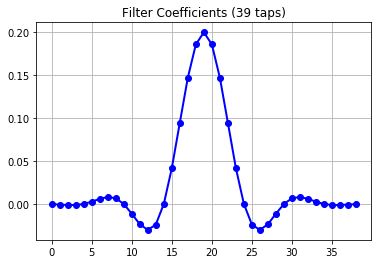

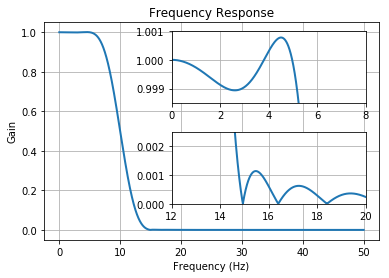

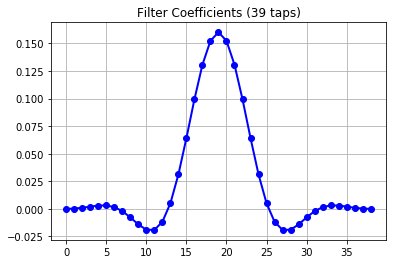

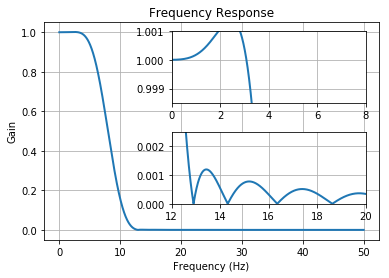

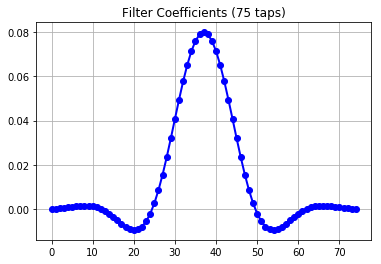

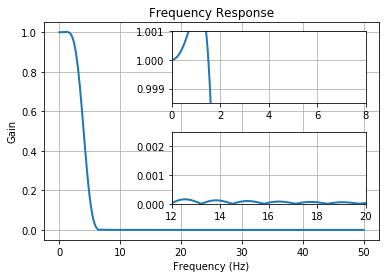

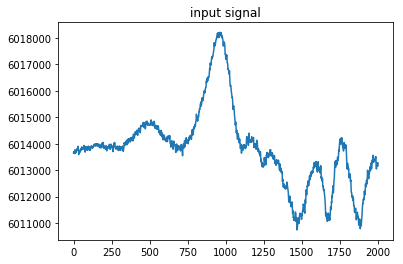

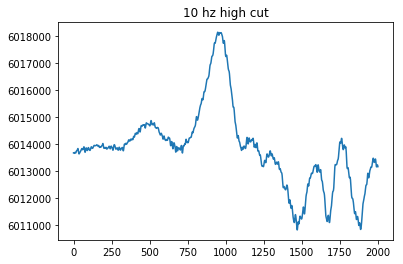

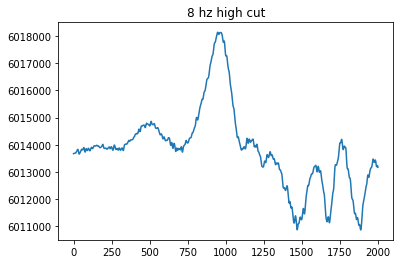

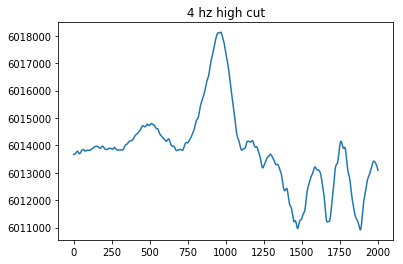

In [18]:
#plot comparisons

# 10 hz (this repeats a previous computations to help you write the 
#        8 and 4 hz hicut filters)
filter10=design_highcutfilter(sample_rate,width=10,cutoff_hz = 10.0)
dknuug0_filtered10 = apply_0ph_filt(filter10, dknuug0) 

#8 hz
# write your code here - fix the ?
filter8=design_highcutfilter(sample_rate,width=10,cutoff_hz = 8)
dknuug0_filtered8 = apply_0ph_filt(filter8, dknuug0) 

#4 hz - you need to change the width so the transition zone 
# [cutoff_hz-width,cutoff_hz+width] make sense.  I recommend a width
# of 5 or 6.  If you make width smaller it will make the filter longer.
# I guess at some point it will become too long and the program will fail.

filter4=design_highcutfilter(sample_rate,width=5,cutoff_hz = 4)
dknuug0_filtered4 = apply_0ph_filt(filter4, dknuug0) 

plt.title('input signal')
plt.plot(dknuug0[596000:596000+2000])
plt.show()

plt.title('10 hz high cut')
plt.plot(dknuug0_filtered10[596000:596000+2000])
plt.show()

# plot 8 hz

plt.title('8 hz high cut')
plt.plot(dknuug0_filtered8[596000:596000+2000])
plt.show()

# plot 4 hz

plt.title('4 hz high cut')
plt.plot(dknuug0_filtered4[596000:596000+2000])
plt.show()





### Continue the filter test
Try high cut filters at 4,2,1, and .5 hz.  This can be run starting with the data highcut filtered to 10 Hz with input data from every 4 sample (i.e. subsamples by 4).  This will reduce computations.

At some point the signal is distored.  What filter do you like best?
 

100.0


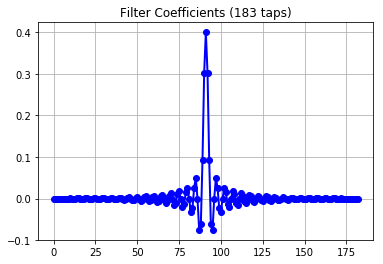

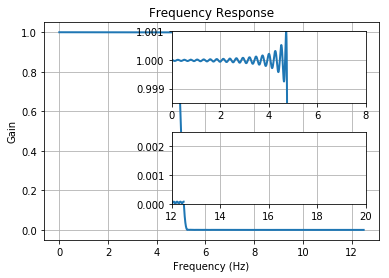

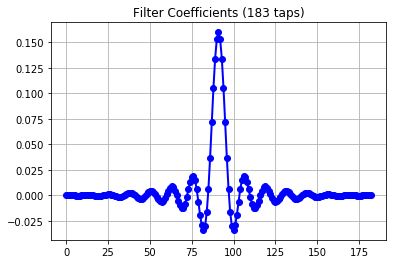

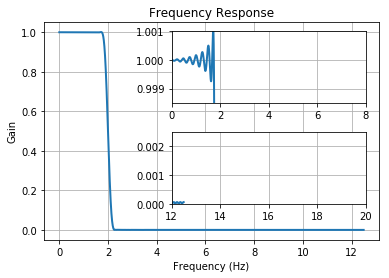

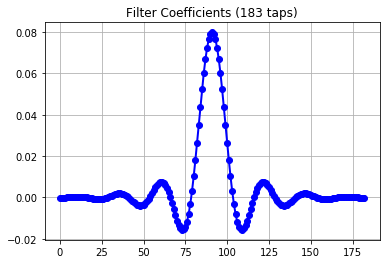

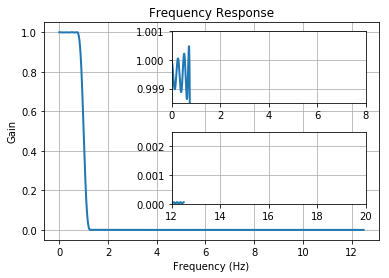

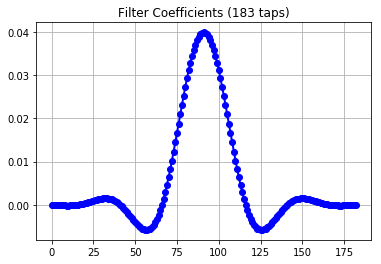

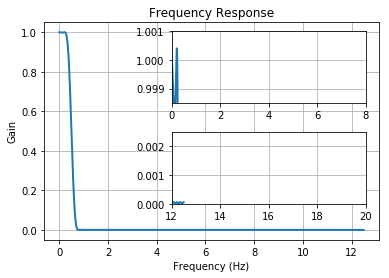

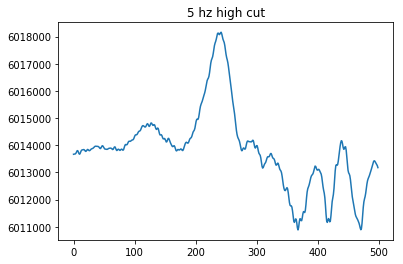

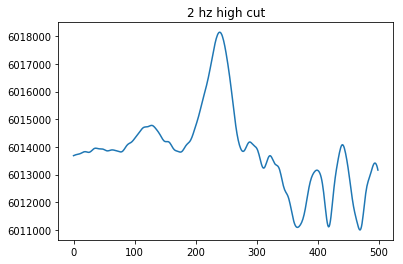

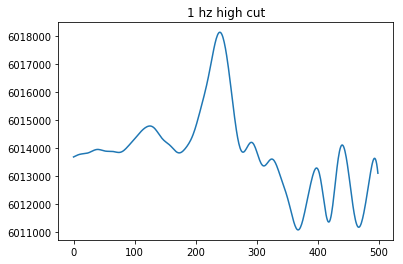

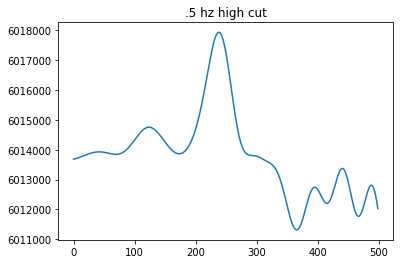

In [21]:
# subsample the data after 10 hz high cut.  Take every 4th sample
dknuug0_25hz=dknuug0_filtered10[::4]
sample_rate25=sample_rate/4
print (sample_rate)

#Make high cut filters at 5,2,1, and .5 hz
filter5=design_highcutfilter(sample_rate25,width=.5,cutoff_hz=5)
dknuug0_filtered5 = apply_0ph_filt(filter5, dknuug0_25hz) 

filter2=design_highcutfilter(sample_rate25,width=.5,cutoff_hz=2)
dknuug0_filtered2 = apply_0ph_filt(filter2, dknuug0_25hz) 
filter1=design_highcutfilter(sample_rate25,width=.5,cutoff_hz=1)
dknuug0_filtered1 = apply_0ph_filt(filter1, dknuug0_25hz) 
filterp5=design_highcutfilter(sample_rate25,width=.5,cutoff_hz=.5)
dknuug0_filteredp5 = apply_0ph_filt(filterp5, dknuug0_25hz) 




plt.title('5 hz high cut')
plt.plot(dknuug0_filtered5[596000//4:(596000+2000)//4])
plt.show()

plt.title('2 hz high cut')
plt.plot(dknuug0_filtered2[596000//4:(596000+2000)//4])
plt.show()

plt.title('1 hz high cut')
plt.plot(dknuug0_filtered1[596000//4:(596000+2000)//4])
plt.show()

plt.title('.5 hz high cut')
plt.plot(dknuug0_filteredp5[596000//4:(596000+2000)//4])
plt.show()







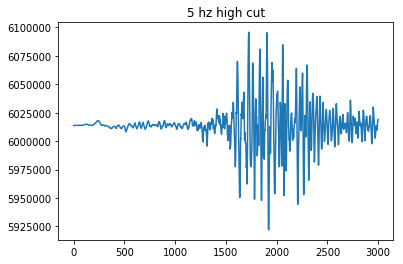

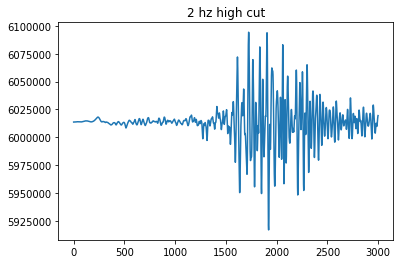

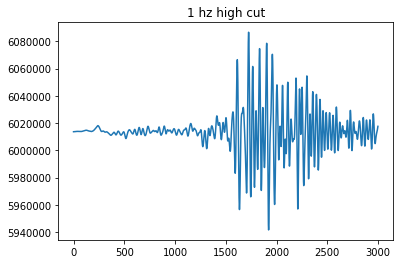

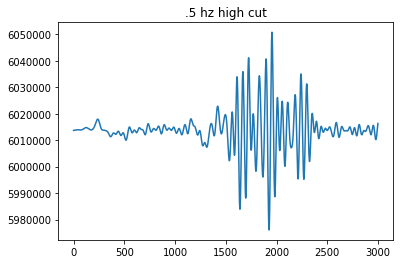

In [22]:
 #replot a longer section of the filterred data
plt.title('5 hz high cut')
plt.plot(dknuug0_filtered5[596000//4:(596000+12000)//4])
plt.show()

plt.title('2 hz high cut')
plt.plot(dknuug0_filtered2[596000//4:(596000+12000)//4])
plt.show()

plt.title('1 hz high cut')
plt.plot(dknuug0_filtered1[596000//4:(596000+12000)//4])
plt.show()

plt.title('.5 hz high cut')
plt.plot(dknuug0_filteredp5[596000//4:(596000+12000)//4])
plt.show()

   